# Static preprocessing implementations

Getting some sample data we can test the classes on

In [1]:
%cd ..

/data/mas322/amex-project


In [3]:
import yaml
import os
import importlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn
import matplotlib.pyplot as plt

from src.lib import experimentation
from src.models import basic_grunet
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# Note this should follow the interface of sklearn BaseEstimator using a fit, transform and fit_transform function
class IdentityTransform(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        # https://docs.cupy.dev/en/stable/user_guide/interoperability.html#pytorch
        # consider using cupy if too slow with base numpy ^^
        return self
    
    def transform(self, X):
        return X

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : True,
    'drop_last' : True,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

np.random.seed(42)
torch.manual_seed(42)

# load corrupted data
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=spm.undo_min_max_corrupt_func,
    **data_loader_kwargs)

for X, y in train_loader:
    break
X, y = X.numpy()[:, :, 11:], y.numpy()[11:]
print(f"X shape: {X.shape}")

# also load uncorrupted data for sanity checking
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=None,
    **data_loader_kwargs)
for X_uncorrupted, _ in train_loader:
    break
X_uncorrupted = X_uncorrupted.numpy()[:, :, 11:]

X shape: (1024, 13, 177)


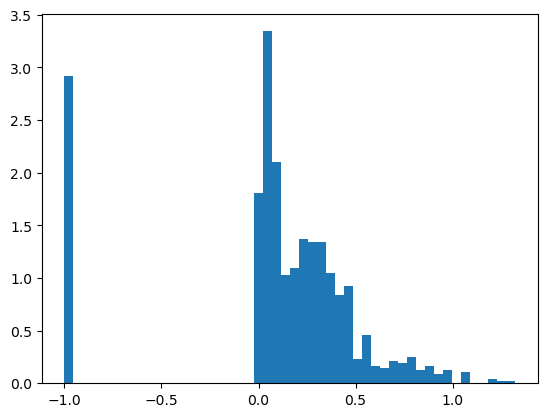

In [7]:
import matplotlib.pyplot as plt

plt.hist(X_uncorrupted[:, 1, 12], bins = 50, density=True)
plt.show()

## Standard scaling

In [16]:
torch.zeros((5,)).is_cuda

False

In [17]:
# TODO

## Decimal scaling

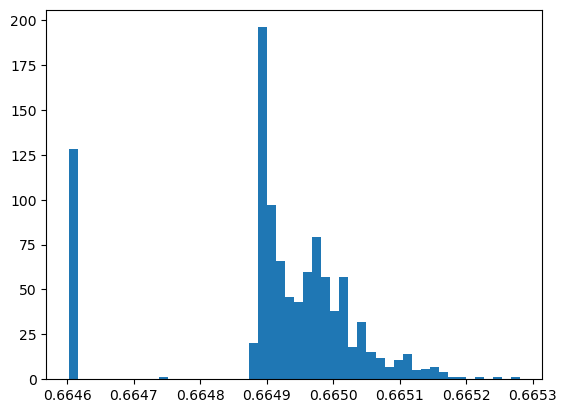

In [5]:
class DecimalScaling(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, time_series_length=13):
        self.T = time_series_length
        pass
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        max_vals = np.max(np.abs(X), axis=0)
        # the exponent (base 10) that each feature should be scaled with
        q = np.array(np.log10(max_vals) + 1, dtype=np.int16)
        self.scale_factor = 1 / np.power(10., q, dtype=np.float32)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features
        X = X * self.scale_factor
        return X.reshape((X.shape[0], self.T, -1))

ds = DecimalScaling()
X_new = ds.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50)
plt.show()

## Min-Max scaling

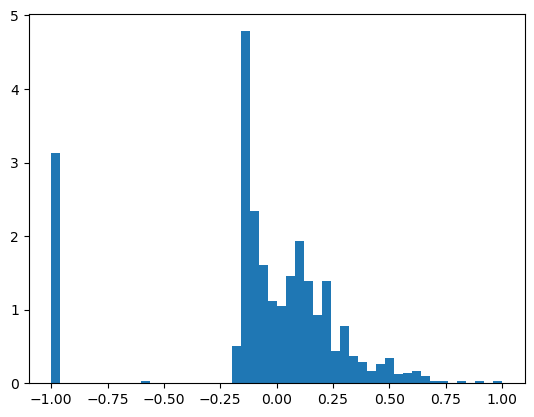

In [28]:
from sklearn import preprocessing

class MinMaxTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, a=0, b=1, time_series_length=13):
        self.T = time_series_length
        self.min_max_scaler = preprocessing.MinMaxScaler(feature_range=(a, b))
        pass
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        self.min_max_scaler.fit(X, y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features
        X = self.min_max_scaler.transform(X)
        return X.reshape((X.shape[0], self.T, -1))

min_max = MinMaxTimeSeries(-1, 1)
X_new = min_max.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50, density=True)
plt.show()

## Log transforms

In [24]:
from sklearn import preprocessing
import matplotlib.pyplot as plt

class LogMinMaxTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, a=0, b=1, alpha=0.025, time_series_length=13):
        self.T = time_series_length
        self.min_max_scaler = preprocessing.MinMaxScaler(feature_range=(a, b))
        self.alpha = alpha
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        
        # find smallest and largest, as we will base our shift on that
        lower = np.min(X, axis=0)
        upper = np.max(X, axis=0)
        # shift all elements up by this value to ensure they are positive
        # Also add one for variables with very small scale, othw might get 0
        self.shift = -lower + (upper - lower) * self.alpha + 1
        
        X = np.log(X + self.shift)
        self.min_max_scaler.fit(X, y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features after shifting
        X = self.min_max_scaler.transform(np.log(X + self.shift))
        return X.reshape((X.shape[0], self.T, -1))
    
class LogStandardScaleTimeSeries(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self, alpha=0.025, time_series_length=13):
        self.T = time_series_length
        self.standard_scaler = preprocessing.StandardScaler()
        self.alpha = alpha
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        
        # find smallest and largest, as we will base our shift on that
        lower = np.min(X, axis=0)
        upper = np.max(X, axis=0)
        # shift all elements up by this value to ensure they are positive
        # Also add one for variables with very small scale, othw might get 0
        self.shift = -lower + (upper - lower) * self.alpha + 1
        
        X = np.log(X + self.shift)
        self.standard_scaler.fit(X, y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # scale all the features after shifting
        X = self.standard_scaler.transform(np.log(X + self.shift))
        return X.reshape((X.shape[0], self.T, -1))

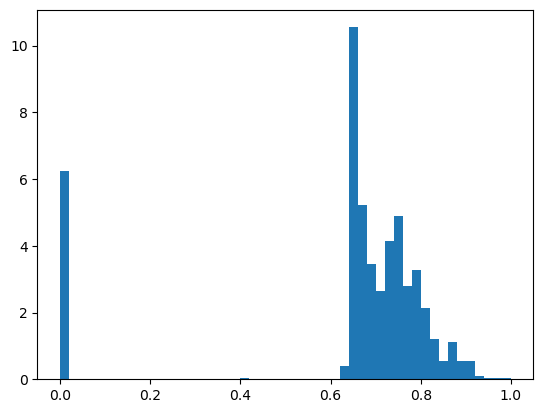

In [26]:
log_min_max = LogMinMaxTimeSeries(alpha=0.03)
X_new = log_min_max.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50, density=True)
plt.show()

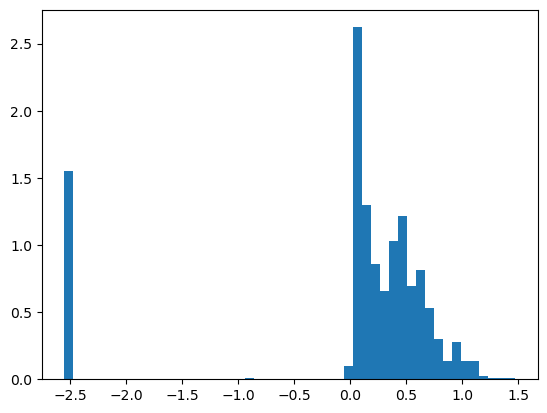

In [27]:
log_min_max = LogStandardScaleTimeSeries(alpha=0.03)
X_new = log_min_max.fit_transform(X, y)
plt.hist(X_new[:, 1, 12], bins=50, density=True)
plt.show()

In [40]:
temp = list(zip([1, 2, 3, 4], [lambda x: LogStandardScaleTimeSeries(x)] * 4))
temp

[(1, <function __main__.<lambda>(x)>),
 (2, <function __main__.<lambda>(x)>),
 (3, <function __main__.<lambda>(x)>),
 (4, <function __main__.<lambda>(x)>)]

In [55]:
temp = np.array([[0.0, 1.3, -0.3, 3232, -103.2], [0.1, -0.3, -3, 5, 7]])
for i in range(temp.shape[1]):
    a = temp[temp[:, i] <= 0.0, i]
    print(a)
raise ValueError("Negative values passed to log. Aborting!")

[0.]
[-0.3]
[-0.3 -3. ]
[]
[-103.2]


ValueError: Negative values passed to log. Aborting!

## Analysing results

In [ ]:
no_preprocess = np.load(os.path.join(cfg['experiment_directory'], 'no-preprocess-history.npy'), allow_pickle=True).item()
no_preprocess.keys()

dict_keys(['train_loss', 'val_loss', 'train_amex_metric', 'val_amex_metric', 'train_loss_mean', 'train_loss_sd', 'val_loss_mean', 'val_loss_sd', 'train_amex_metric_mean', 'train_amex_metric_sd', 'val_amex_metric_mean', 'val_amex_metric_sd', 'num_epochs'])

In [4]:
import numpy as np

def get_average(history, key):
    vals = []
    epoch = 0
    while True:
        avg_val = 0.
        num_vals = 0
        for i in range(5):
            if len(history[key][i]) > epoch:
                num_vals += 1
                avg_val += history[key][i][epoch]
            else:
                avg_val += history[key][i][-1]
        if num_vals == 0:
            break
        vals.append(avg_val / 5)
        epoch += 1
    return vals

def plot_cv(history, suffix, ax, cols = ['tab:blue', 'tab:orange'], **kwargs):
    train_mean = get_average(history, f"train_{suffix}")
    val_mean = get_average(history, f"val_{suffix}")
    # epoch = 0
    # while True:
    #     avg_train_val = 0.
    #     avg_val_val = 0.
    #     num_vals = 0
    #     for i in range(5):
    #         if len(history[f"train_{suffix}"][i]) > epoch:
    #             num_vals += 1
    #             avg_train_val += history[f"train_{suffix}"][i][epoch]
    #             avg_val_val += history[f"val_{suffix}"][i][epoch]
    #     if num_vals == 0:
    #         break
    #     train_mean.append(avg_train_val / num_vals)
    #     val_mean.append(avg_val_val / num_vals)
    #     epoch += 1
    
    for i in range(5):
        ax.plot(history[f"train_{suffix}"][i], alpha = 0.5,
                label = "Train" if i == 0 else None,
                color = cols[0],
                linestyle = 'dashed', **kwargs)
        ax.plot(history[f"val_{suffix}"][i], alpha = 0.5,
                label = "Val" if i == 0 else None,
                color = cols[1],
                linestyle = 'dashed', **kwargs)
        # add red dot if was terminates
        if len(history[f"train_{suffix}"][i]) < len(train_mean):
            ax.plot(len(history[f"train_{suffix}"][i]) - 1, history[f"train_{suffix}"][i][-1], color='red', marker='o', alpha=0.3)
            ax.plot(len(history[f"val_{suffix}"][i]) - 1, history[f"val_{suffix}"][i][-1], color='red', marker='o', alpha=0.3)
    
    ax.plot(train_mean, label="Train (CV mean)", color=cols[0], **kwargs)
    ax.plot(val_mean, label="Val (CV mean)", color=cols[1], **kwargs)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(suffix)
    ax.legend()

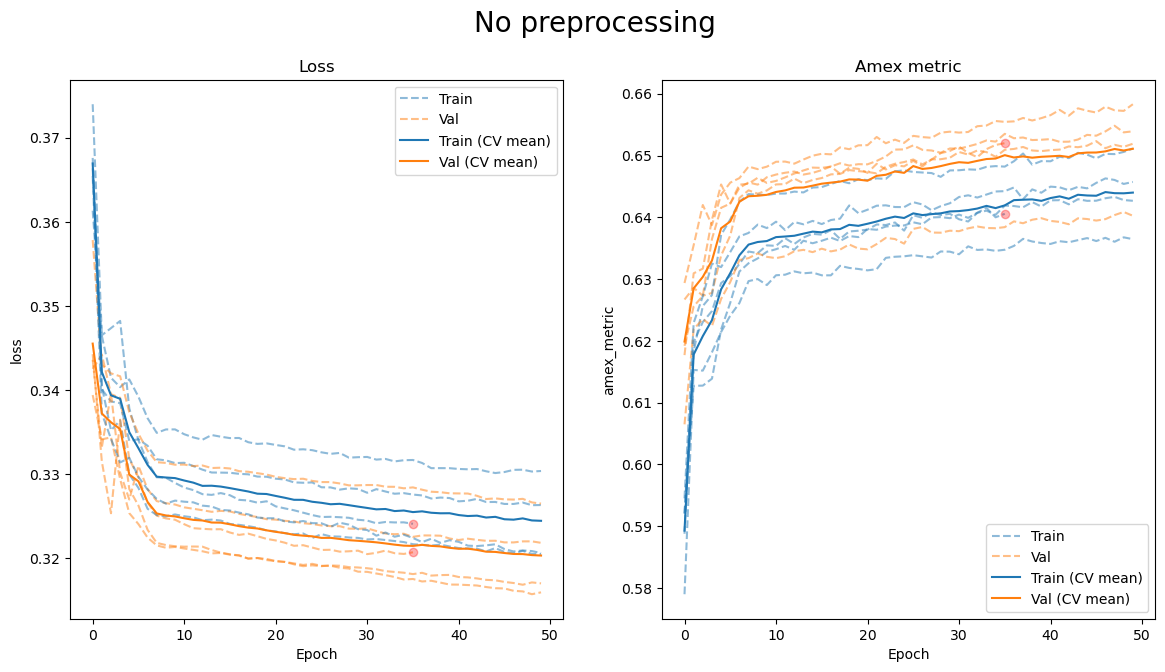

In [104]:
no_preprocess = np.load(os.path.join(cfg['experiment_directory'], 'no-preprocess-history-50-epochs.npy'), allow_pickle=True).item()
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
fig.suptitle("No preprocessing", fontsize=20)
plot_cv(no_preprocess, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(no_preprocess, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
plt.show()

[15, 14, 16, 16, 10]


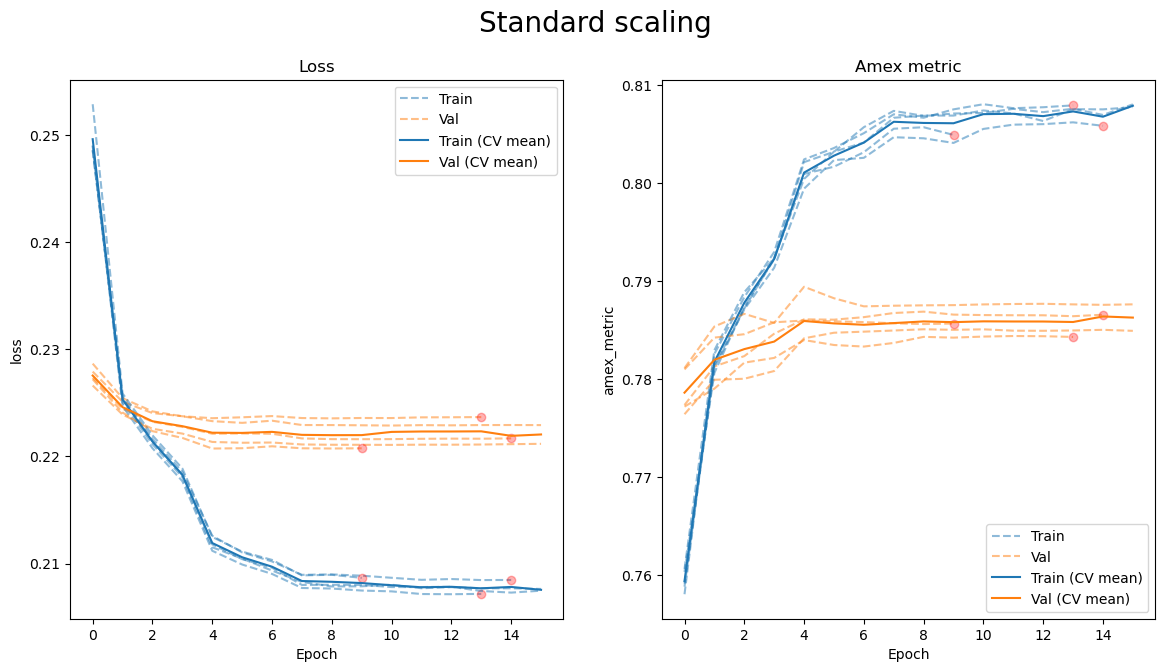

In [105]:
standard_scaling = np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
print(standard_scaling['num_epochs'])
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(standard_scaling, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(standard_scaling, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Standard scaling", fontsize=20)
plt.show()

In [92]:
!ls /home/silo1/mas322/experiment-results

min-max-scaling-history-50-epochs.npy
min-max-scaling-history.npy
no-preprocess-history-50-epochs.npy
no-preprocess-history.npy
standard-scaling-history-50-epochs.npy
standard-scaling-history-no-corrupt.npy
standard-scaling-history.npy
tanh-standard-scaling-history-50-epochs.npy


[24, 21, 37, 50, 41]


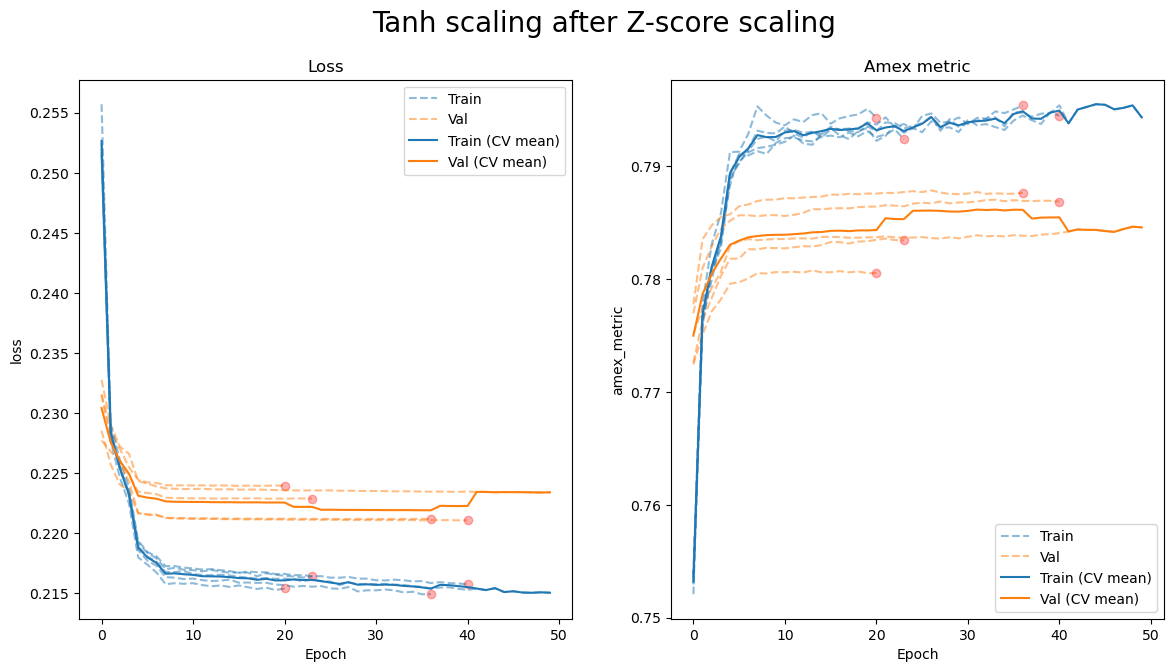

In [106]:
tanh_scaling = np.load(os.path.join(cfg['experiment_directory'], 'tanh-standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()
print(tanh_scaling['num_epochs'])
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(tanh_scaling, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(tanh_scaling, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Tanh scaling after Z-score scaling", fontsize=20)
plt.show()

[50, 50, 50, 50, 50]


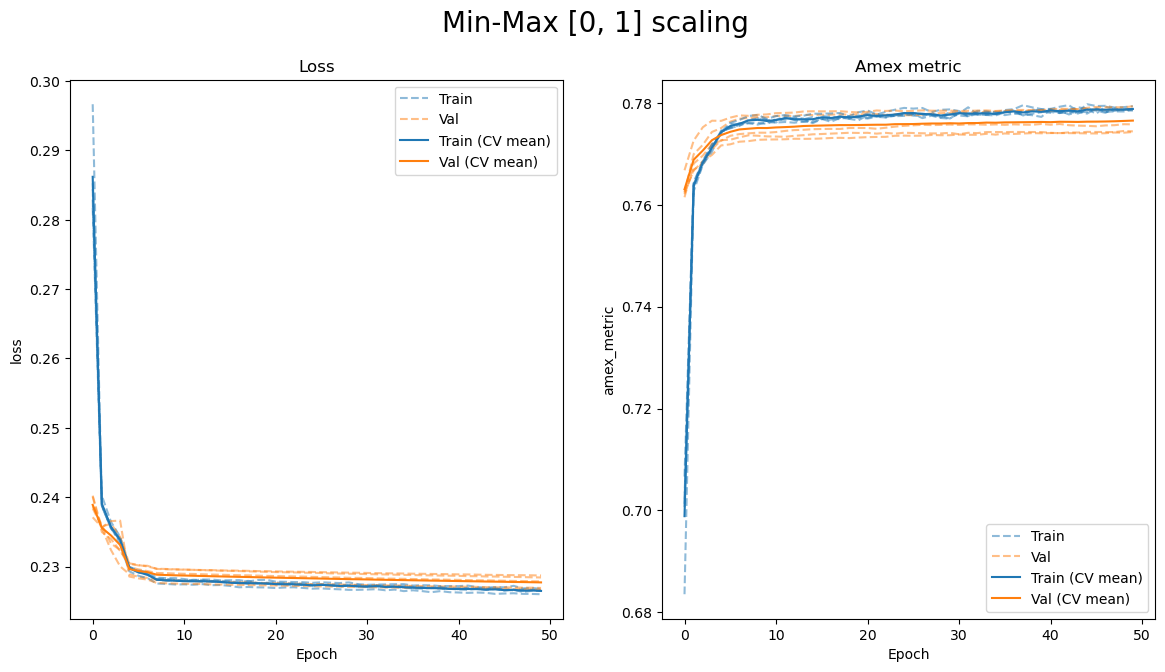

In [97]:
min_max = np.load(os.path.join(cfg['experiment_directory'], 'min-max-scaling-history-50-epochs.npy'), allow_pickle=True).item()
print(min_max['num_epochs'])
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(min_max, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(min_max, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Min-Max [0, 1] scaling", fontsize=20)
plt.show()

Plotting all the different preprocessing methods

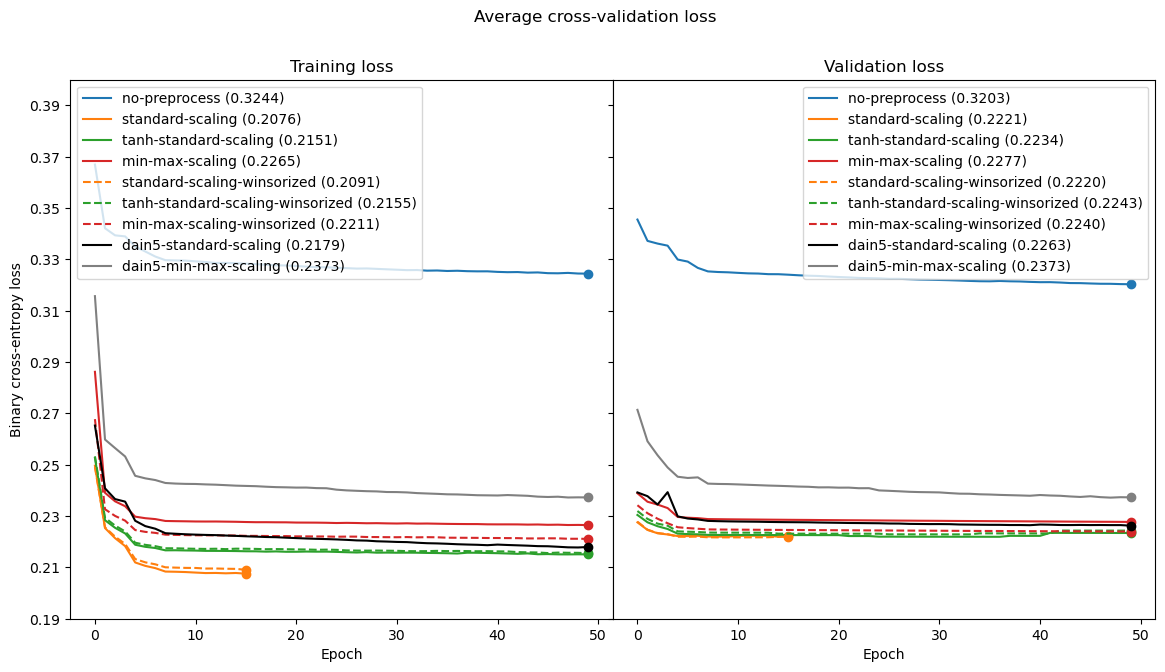

In [22]:
import matplotlib.pyplot as plt
methods = ['no-preprocess', 'standard-scaling', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized', 'dain5-standard-scaling', 'dain5-min-max-scaling']

fig, axs = plt.subplots(ncols = 2, figsize=(14, 7), sharey=True)
fig.subplots_adjust(wspace=0)

for m, c in zip(methods, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:orange', 'tab:green', 'tab:red', 'black', 'grey']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_loss")
    val_cv_avgs = get_average(history, "val_loss")
    if 'winsorized' in m:
        linestyle = '--'
    else:
        linestyle = '-'
    axs[0].plot(train_cv_avgs, label = f"{m} ({train_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[0].plot(len(train_cv_avgs) - 1, train_cv_avgs[-1], marker='o', color=c)
    axs[0].set_yticks(np.arange(0.19, 0.40, 0.02))
    axs[0].set_ylim([0.19, 0.40])
    axs[1].set_yticks(np.arange(0.19, 0.40, 0.02))
    axs[1].set_ylim([0.19, 0.40])
    axs[1].plot(val_cv_avgs, label = f"{m} ({val_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[1].plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c)
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Binary cross-entropy loss")
axs[0].set_title("Training loss")
axs[1].set_title("Validation loss")
axs[1].legend()
fig.suptitle("Average cross-validation loss")
plt.show()

Below cell used to producde the plot for the **poster presentation**.

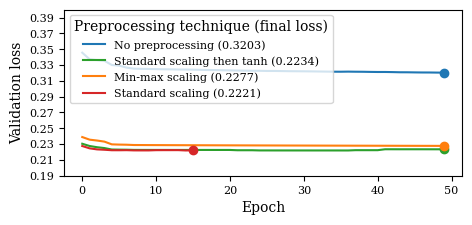

In [16]:
import matplotlib.pyplot as plt
methods = ['no-preprocess', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling'] #, 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized']
tex_fonts = {
    "text.usetex": False,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 12,
    "legend.fontsize": 8,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 8,  # 8 at full scale
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)

fig, ax = plt.subplots(figsize=(300 * 1/0.8 / 73, 280 * 3/4 * 1/0.8 / 73 * 0.6))
fig.subplots_adjust(wspace=0)

for m, c, lab in zip(methods, ['tab:blue', 'tab:green', 'tab:orange', 'tab:red'], ['No preprocessing', 'Standard scaling then tanh', 'Min-max scaling', 'Standard scaling']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_loss")
    val_cv_avgs = get_average(history, "val_loss")
    ax.set_yticks(np.arange(0.19, 0.40, 0.02))
    ax.set_ylim([0.19, 0.40])
    ax.plot(val_cv_avgs, label = f"{lab} ({val_cv_avgs[-1]:.4f})", color=c, linestyle='-')
    ax.plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c, markersize=6)
ax.legend(loc="upper left", title="Preprocessing technique (final loss)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation loss")
# ax.set_title("Validation loss")
# axs[1].set_title("Validation loss")
# axs[1].legend()
# fig.suptitle("Average cross-validation loss")
# plt.show()
fig.savefig("/home/mas322/amex-project/reports/poster/Figures/poster-val-loss.pdf", bbox_inches='tight')
#plt.show()

In [49]:
list(zip([1, 2], [3, 4], [5, 6]))

[(1, 3, 5), (2, 4, 6)]

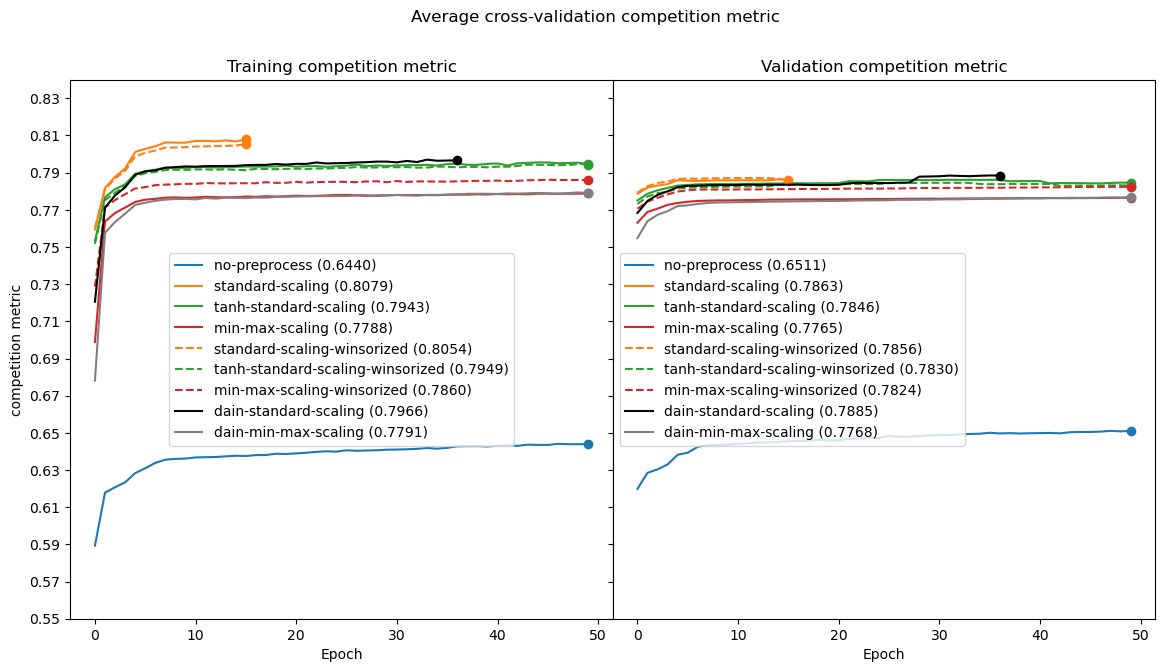

In [21]:
methods = ['no-preprocess', 'standard-scaling', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized']
methods = ['no-preprocess', 'standard-scaling', 'tanh-standard-scaling', 'min-max-scaling', 'standard-scaling-winsorized', 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized', 'dain-standard-scaling', 'dain-min-max-scaling']


fig, axs = plt.subplots(ncols = 2, figsize=(14, 7), sharey=True)
fig.subplots_adjust(wspace=0)

for m, c in zip(methods, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:orange', 'tab:green', 'tab:red', 'black', 'grey']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_amex_metric")
    val_cv_avgs = get_average(history, "val_amex_metric")
    if 'winsorized' in m:
        linestyle = '--'
    else:
        linestyle = '-'
    axs[0].plot(train_cv_avgs, label = f"{m} ({train_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[0].plot(len(train_cv_avgs) - 1, train_cv_avgs[-1], marker='o', color=c)
    axs[0].set_yticks(np.arange(0.55, 0.84, 0.02))
    axs[0].set_ylim([0.55, 0.85])
    axs[1].set_yticks(np.arange(0.55, 0.84, 0.02))
    axs[1].set_ylim([0.55, 0.84])
    axs[1].plot(val_cv_avgs, label = f"{m} ({val_cv_avgs[-1]:.4f})", color=c, linestyle=linestyle)
    axs[1].plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c)
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("competition metric")
axs[0].set_title("Training competition metric")
axs[1].set_title("Validation competition metric")
axs[1].legend()
fig.suptitle("Average cross-validation competition metric")
plt.show()

## Winsorization

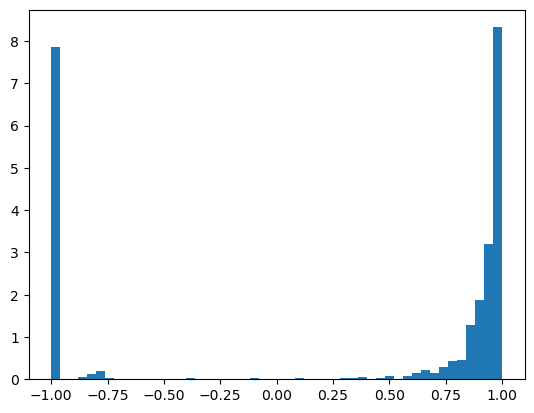

In [66]:
class WinsorizeDecorator(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    """
    Before fitting provided transformer winsorizes the data to be within
    the [alpha/2, 1-alpha/2] quantiles of the fitted data.
    """
    def __init__(self, TransformerClass, alpha=0.05, time_series_length=13, **kwargs):
        self.transformer = TransformerClass(**kwargs)
        self.T = time_series_length
        self.alpha = alpha
    
    def fit(self, X, y = None):
        # merge the dimensions and time axis
        X = X.reshape((X.shape[0], -1))
        # save the quantiles for each of the T * D variables
        self.lower = np.quantile(X.reshape((X.shape[0], -1)), q=self.alpha/2, axis=0)
        self.upper = np.quantile(X.reshape((X.shape[0], -1)), q=1-self.alpha/2, axis=0)
        # transform the data
        X = np.clip(X, self.lower, self.upper)
        # then fit the provided transformer on this winsorized data
        self.transformer = self.transformer.fit(X.reshape((X.shape[0], self.T, -1)), y)
        return self
    
    def transform(self, X):
        X = X.reshape((X.shape[0], -1))
        # clip all the features based on the learned percentiles
        X = np.clip(X, self.lower, self.upper)
        # apply the provided transformer
        return self.transformer.transform(X.reshape((X.shape[0], self.T, -1)))
    
min_max = MinMaxTimeSeries(-1, 1)
winsor_min_max = WinsorizeDecorator(MinMaxTimeSeries, alpha=0.4, a=-1, b=1)
X_new = winsor_min_max.fit_transform(X, y)
plt.hist(X_new[:, 2, 123], bins=50, density=True)
plt.show()

In [27]:
lower = np.quantile(X.reshape((X.shape[0], -1)), q=0.025, axis=0)
upper = np.quantile(X.reshape((X.shape[0], -1)), q=0.975, axis=0)
np.clip(X.reshape((X.shape[0], -1)), lower, upper)[:,2]

array([4639.88671875, 4639.88427734, 4639.88183594, ..., 4639.21044922,
       4639.88964844, 4639.8828125 ])

## Performance with DAIN

In [ ]:
%cd ..

In [46]:
import yaml
import os
import importlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sklearn

from src.lib import experimentation
from src.models import basic_grunet
import src.experiments.static_preprocessing_methods.experiment_setup as spm

with open(os.path.join("config.yaml")) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

# Note this should follow the interface of sklearn BaseEstimator using a fit, transform and fit_transform function
class IdentityTransform(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        # https://docs.cupy.dev/en/stable/user_guide/interoperability.html#pytorch
        # consider using cupy if too slow with base numpy ^^
        return self
    
    def transform(self, X):
        return X

data_loader_kwargs = {
    'batch_size' : 1024,
    'shuffle' : True,
    'drop_last' : True,
}

fill_dict = {
    'nan' : -0.5,
    'pad_categorical' : -2,
    'pad_numeric' : -1.,
}

np.random.seed(42)
torch.manual_seed(42)

# load corrupted data
train_loader, val_loader = experimentation.load_numpy_data(
    os.path.join(cfg['dataset_directory'], "derived", "processed-splits"),
    val_idx=[0, 1],
    fill_dict=fill_dict,
    preprocess_obj=IdentityTransform(),
    corrupt_func=None, # spm.undo_min_max_corrupt_func,
    **data_loader_kwargs)

In [48]:
import importlib.util
import sys

# import the DAIN layer (Usage: dain.DAIN_Layer(...) )
spec = importlib.util.spec_from_file_location("dain", os.path.join(cfg['dain_repo'], 'dain.py'))
dain = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = dain
spec.loader.exec_module(dain)

class GRUNetBasic(nn.Module):
    def __init__(self, num_features, hidden_dim, layer_dim, emb_dim, num_cat_columns = 11, dropout_prob = 0.2):
        super(GRUNetBasic, self).__init__()

        # save the params
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        self.num_cat_columns = num_cat_columns

        # to get current device
        self.dummy_param = nn.Parameter(torch.empty(0))

        # the layers we need
        emb_layers = []
        for k in range(num_cat_columns):
            emb_layers.append(nn.Embedding(10, emb_dim))
        self.emb_layers = nn.ModuleList(emb_layers)

        self.gru = nn.GRU(
                input_size = num_features - num_cat_columns + num_cat_columns * emb_dim,
                hidden_size = hidden_dim,
                num_layers = layer_dim,
                batch_first = True,
                dropout = dropout_prob
                )

        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # First 11 columns are categorical, next 177 are numerical
        embedding_outs = []
        for k in range(self.num_cat_columns):
            emb = self.emb_layers[k]
            col = x[:, :, k].type(torch.int32)
            embedding_outs.append(emb(col))

        x = torch.concat([x[:, :, self.num_cat_columns:]] + embedding_outs, dim = -1)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device = self.dummy_param.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.sigmoid(self.fc3(out))

        return out.squeeze(1)

In [49]:
from src.models.basic_grunet import GRUNetBasic

# mode='adaptive_avg', mean_lr=0.00001, gate_lr=0.001, scale_lr=0.00001, input_dim=144)  
class DainGRUNet(nn.Module):
    def __init__(self, num_features, hidden_dim, layer_dim, emb_dim, num_cat_columns = 11, dropout_prob = 0.2, **dain_kwargs):
        super(DainGRUNet, self).__init__()

        # save the params
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim
        self.num_cat_columns = num_cat_columns

        # to get current device
        self.dummy_param = nn.Parameter(torch.empty(0))

        # the layers we need
        emb_layers = []
        for k in range(num_cat_columns):
            emb_layers.append(nn.Embedding(10, emb_dim))
        self.emb_layers = nn.ModuleList(emb_layers)

        self.gru = nn.GRU(
                input_size = num_features - num_cat_columns + num_cat_columns * emb_dim,
                hidden_size = hidden_dim,
                num_layers = layer_dim,
                batch_first = True,
                dropout = dropout_prob
                )

        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
        # DAIN preprocessing layer
        self.dain = dain.DAIN_Layer(input_dim=num_features - num_cat_columns, **dain_kwargs)

    def forward(self, x):
        # First 11 columns are categorical, next 177 are numerical
        embedding_outs = []
        for k in range(self.num_cat_columns):
            emb = self.emb_layers[k]
            col = x[:, :, k].type(torch.int32)
            embedding_outs.append(emb(col))
            
        # apply DAIN preprocessing just on the numeric columns
        dain_out = self.dain(x[:, :, self.num_cat_columns:].transpose(1, 2))

        x = torch.concat([dain_out.transpose(1, 2)] + embedding_outs, dim = -1)

        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device = self.dummy_param.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.sigmoid(self.fc3(out))

        return out.squeeze(1)

In [63]:
from src.lib.experimentation import fit_model

mean_lr, std_lr, scale_lr = 1e-04, 0.001, 10

model = DainGRUNet(188, 128, 2, 4, mode='full', mean_lr=mean_lr, scale_lr=std_lr, gate_lr=scale_lr)
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 30], gamma=0.1)

history = fit_model(model, loss_fn, train_loader, val_loader, optimizer, scheduler, num_epochs=100)

Mode =  full


  0%|          | 0/100 [00:00<?, ?it/s]

/home/mas322/anaconda3/envs/cudf-torch/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


LOSS train 0.3261359772702169 valid 0.26326956591579354
AMEX metric train 0.6294815361538032 valid 0.7326316233788096
LOSS train 0.2553887463398486 valid 0.24913113857253213
AMEX metric train 0.7415844612417345 valid 0.7497781281868101
LOSS train 0.24933709811897917 valid 0.2458190569716893
AMEX metric train 0.7515690900376337 valid 0.7555575642022115
LOSS train 0.24428902516484927 valid 0.24413669142830238
AMEX metric train 0.7581486401356177 valid 0.7610498170428529
LOSS train 0.2402038841440691 valid 0.23814533081617248
AMEX metric train 0.7621114284144722 valid 0.7637216202886448
LOSS train 0.24019212525483616 valid 0.23854664637801354
AMEX metric train 0.7636003241007182 valid 0.763312949405903
LOSS train 0.23715906968995845 valid 0.23903845267349413
AMEX metric train 0.7673996464027283 valid 0.7694764808553222
LOSS train 0.23539148046317712 valid 0.23469078088744302
AMEX metric train 0.7697546546096086 valid 0.7705502500672302
LOSS train 0.23445733594994306 valid 0.24652792563599

In [6]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.plot(np.load(os.path.join(cfg['experiment_directory'], 'standard-scaling-history-50-epochs.npy'), allow_pickle=True).item()['val_loss'][0])
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [67]:
np.min(history['val_loss'])

0.22805817358279495

## Mixed preprocessing results

Final val loss: 0.2220 val metric: 0.7858


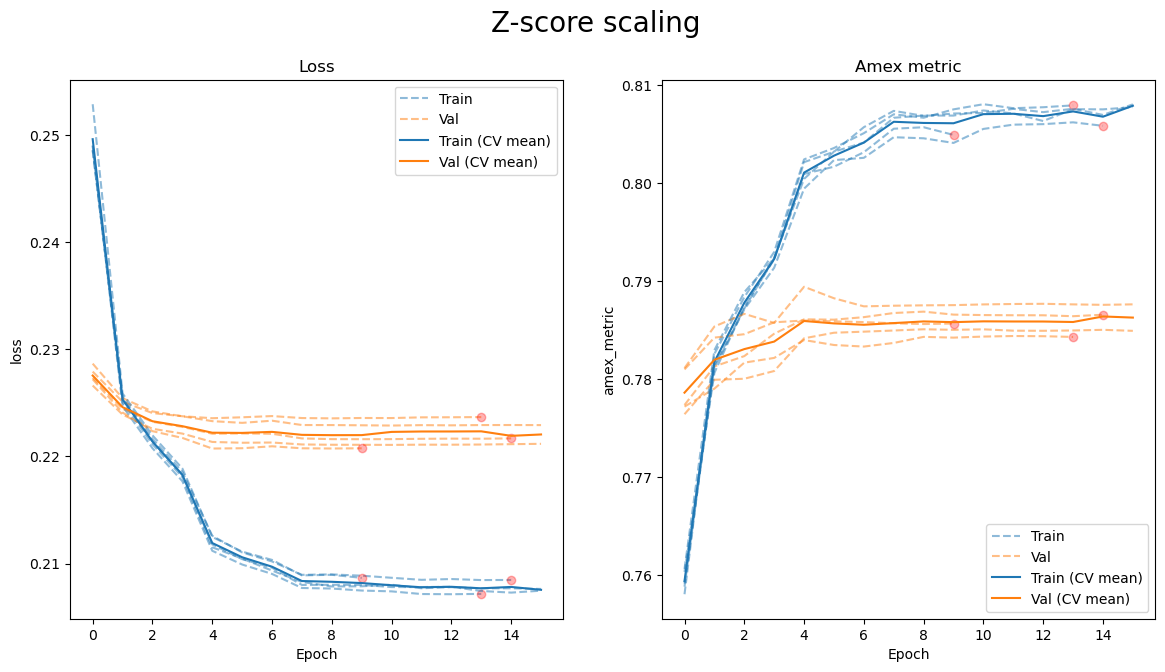

In [15]:
# Yes, clear from this plot that the baseline model is exactly the same as the standard scaling method, so MixedTransform class works!
baseline_hist =  np.load("/home/silo1/mas322/experiment-results/mixed-transform-baseline.npy", allow_pickle=True).item()
print(f"Final val loss: {baseline_hist['val_loss_mean']:.4f} val metric: {baseline_hist['val_amex_metric_mean']:.4f}")
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(baseline_hist, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(baseline_hist, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
fig.suptitle("Z-score scaling", fontsize=20)
plt.show()

Final val loss: 0.2223 val metric: 0.7863


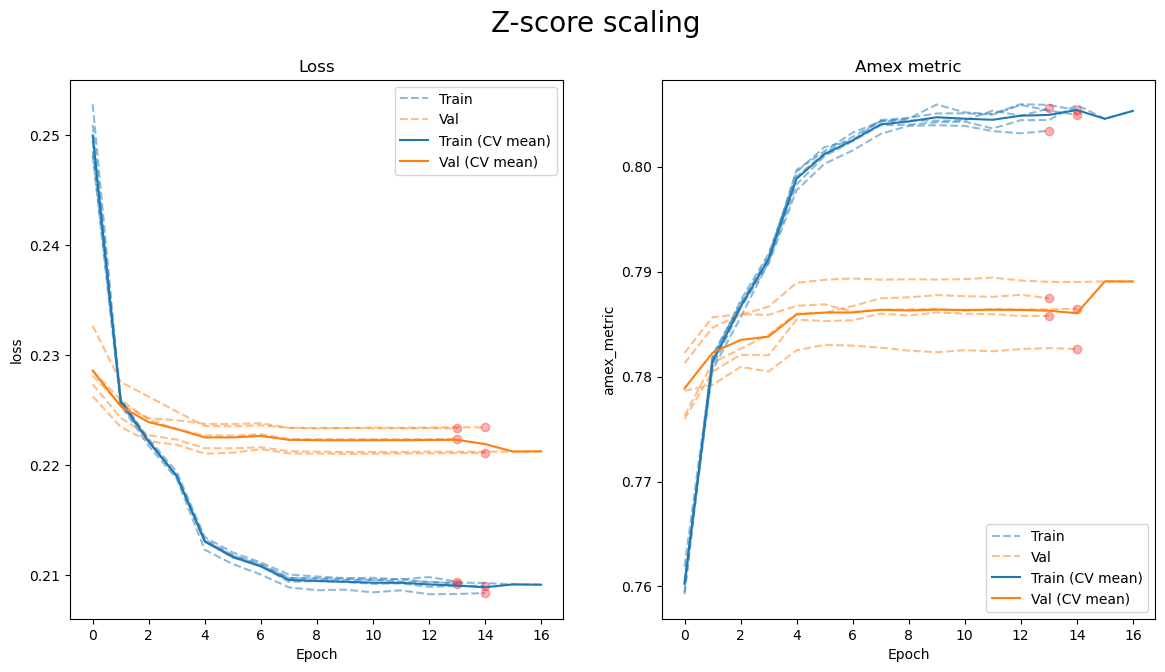

In [27]:
hist =  np.load("/home/silo1/mas322/experiment-results/mixed-transform-group-0-min-max.npy", allow_pickle=True).item()
print(f"Final val loss: {hist['val_loss_mean']:.4f} val metric: {hist['val_amex_metric_mean']:.4f}")
fig, axs = plt.subplots(ncols=2, figsize=(14, 7))
plot_cv(hist, "loss", axs[0])
axs[0].set_title("Loss")
plot_cv(hist, "amex_metric", axs[1])
axs[1].set_title("Amex metric")
# axs[1].axhline(0.7862)
fig.suptitle("Z-score scaling", fontsize=20)
plt.show()

In [3]:
!ls /home/silo1/mas322/experiment-results/

dain2-min-max-scaling-history-50-epochs.npy
dain2-standard-scaling-history-50-epochs.npy
dain3-min-max-scaling-history-50-epochs.npy
dain3-standard-scaling-history-50-epochs.npy
dain4-min-max-scaling-history-50-epochs.npy
dain4-standard-scaling-history-50-epochs.npy
dain5-min-max-scaling-history-50-epochs.npy
dain5-standard-scaling-history-50-epochs.npy
dain6-min-max-scaling-history-50-epochs.npy
dain6-standard-scaling-history-50-epochs.npy
dain-min-max-scaling-history-50-epochs.npy
dain-standard-scaling-history-50-epochs.npy
min-max-scaling-history-50-epochs.npy
min-max-scaling-history.npy
min-max-scaling-winsorized-history-50-epochs.npy
mixed-transform-baseline.npy
mixed-transform-group-0-log-min-max.npy
mixed-transform-group-0-log-standard.npy
mixed-transform-group-0-min-max.npy
mixed-transform-group-0-tanh-standard.npy
mixed-transform-group-1-log-min-max.npy
mixed-transform-group-1-log-standard.npy
mixed-transform-group-1-min-max.npy
mixed-transform-group-1-tanh-standard.npy
mixed-

In [27]:
methods = ['log-min-max', 'log-standard', 'min-max', 'tanh-standard']
group_ids = list(range(9))
baseline_hist = np.load("/home/silo1/mas322/experiment-results/mixed-transform-baseline.npy", allow_pickle=True).item()
print(f"Baseline validation loss: {baseline_hist['val_loss_mean']:.4f}")
print(f"Baseline validation metric: {baseline_hist['val_amex_metric_mean']:.4f}")

metric = 'val_loss_mean'

for gid in group_ids:
    best_method = 'standard-scaling'
    best_loss = baseline_hist[metric]
    print(f"Group {gid+1}:")
    print(f"   standard-scaling -> {best_loss:.4f}")
    for m in methods:
        hist = np.load(f"/home/silo1/mas322/experiment-results/mixed-transform-group-{gid}-{m}.npy", allow_pickle=True).item()
        print(f"   {m} -> {hist[metric]:.4f}")
        if hist[metric] < best_loss:
            best_loss = hist[metric]
            best_method = m
    print(f"   Best method: {best_method} -> {np.abs(baseline_hist[metric] - best_loss):.4f} improvement")


Baseline validation loss: 0.2220
Baseline validation metric: 0.7858
Group 1:
   standard-scaling -> 0.2220
   log-min-max -> 0.2223
   log-standard -> 0.2221
   min-max -> 0.2223
   tanh-standard -> 0.2221
   Best method: standard-scaling -> 0.0000 improvement
Group 2:
   standard-scaling -> 0.2220
   log-min-max -> 0.2223
   log-standard -> 0.2220
   min-max -> 0.2224
   tanh-standard -> 0.2220
   Best method: tanh-standard -> 0.0001 improvement
Group 3:
   standard-scaling -> 0.2220
   log-min-max -> 0.2239
   log-standard -> 0.2221
   min-max -> 0.2238
   tanh-standard -> 0.2230
   Best method: standard-scaling -> 0.0000 improvement
Group 4:
   standard-scaling -> 0.2220
   log-min-max -> 0.2232
   log-standard -> 0.2221
   min-max -> 0.2231
   tanh-standard -> 0.2222
   Best method: standard-scaling -> 0.0000 improvement
Group 5:
   standard-scaling -> 0.2220
   log-min-max -> 0.2220
   log-standard -> 0.2220
   min-max -> 0.2220
   tanh-standard -> 0.2213
   Best method: tanh-stan

Baseline model loss: 0.2220 +- 0.0021
Improved model loss: 0.2208 +- 0.0022
Baseline model AMEX metric: 0.7858 +- 0.0023
Baseline model AMEX metric: 0.7874 +- 0.0056


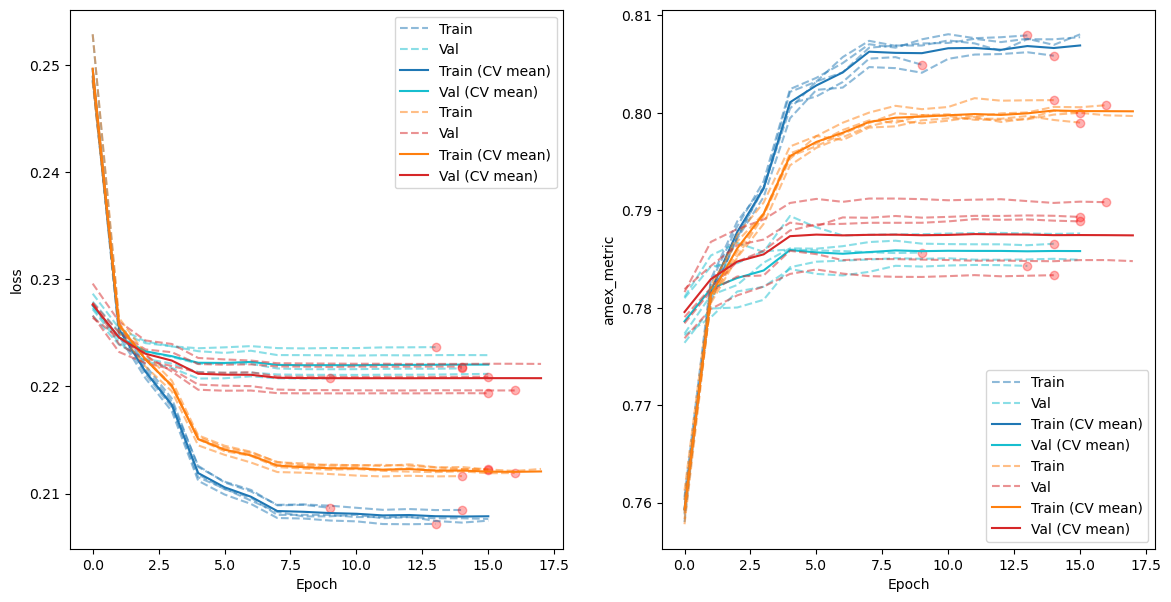

In [5]:
opt_hist = np.load("/home/silo1/mas322/experiment-results/mixed-transform-optimal.npy", allow_pickle=True).item()
baseline_hist = np.load("/home/silo1/mas322/experiment-results/mixed-transform-baseline.npy", allow_pickle=True).item()

fig, axs = plt.subplots(ncols=2, figsize=(14, 7))

# first model: blue and cyan
plot_cv(baseline_hist, 'loss', axs[0], cols=['tab:blue', 'tab:cyan'])
plot_cv(baseline_hist, 'amex_metric', axs[1], cols=['tab:blue', 'tab:cyan'])
# second model: Orange and red
plot_cv(opt_hist, 'loss', axs[0], cols=['tab:orange', 'tab:red'])
plot_cv(opt_hist, 'amex_metric', axs[1], cols=['tab:orange', 'tab:red'])

print(f"Baseline model loss: {baseline_hist['val_loss_mean']:.4f} +- {baseline_hist['val_loss_sd'] * 1.96:.4f}")
print(f"Improved model loss: {opt_hist['val_loss_mean']:.4f} +- {opt_hist['val_loss_sd'] * 1.96:.4f}")
print(f"Baseline model AMEX metric: {baseline_hist['val_amex_metric_mean']:.4f} +- {baseline_hist['val_amex_metric_sd'] * 1.96:.4f}")
print(f"Baseline model AMEX metric: {opt_hist['val_amex_metric_mean']:.4f} +- {opt_hist['val_amex_metric_sd'] * 1.96:.4f}")

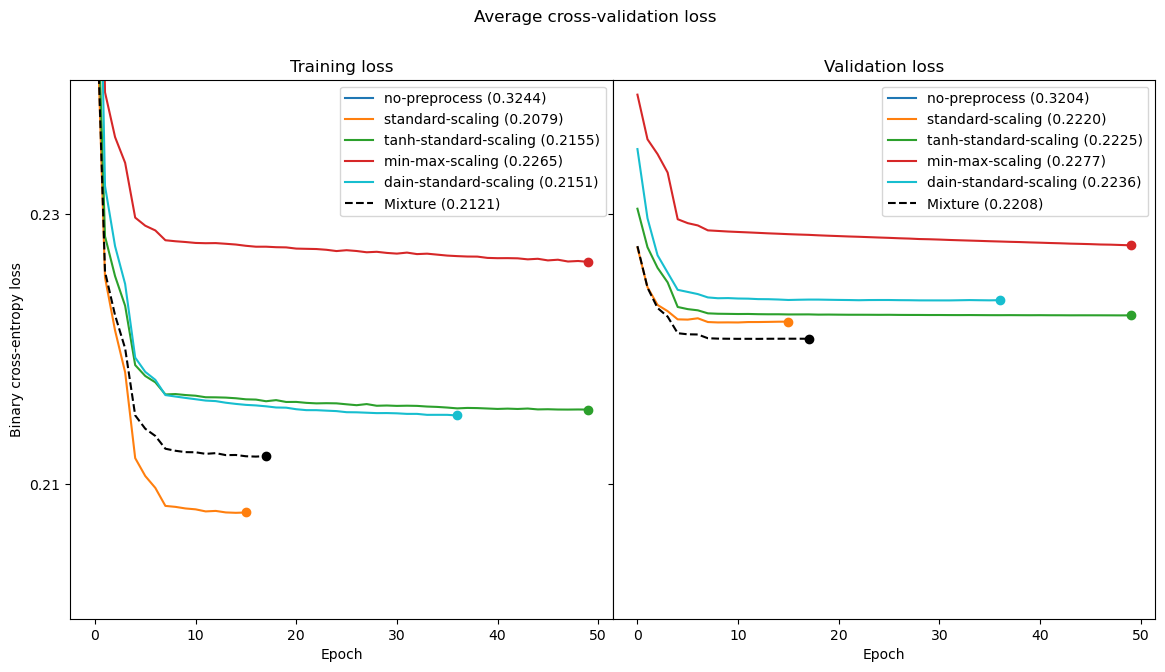

In [11]:
methods = ['no-preprocess', 'standard-scaling', 'tanh-standard-scaling', 'min-max-scaling', 'dain-standard-scaling'] #, 'standard-scaling-winsorized']# , 'tanh-standard-scaling-winsorized', 'min-max-scaling-winsorized', 'dain5-standard-scaling', 'dain5-min-max-scaling']

fig, axs = plt.subplots(ncols = 2, figsize=(14, 7), sharey=True)
fig.subplots_adjust(wspace=0)


for m, c in zip(methods, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:cyan', 'tab:green', 'tab:red', 'black', 'grey']):
    history = np.load(os.path.join(cfg['experiment_directory'], f"{m}-history-50-epochs.npy"), allow_pickle=True).item()
    train_cv_avgs = get_average(history, "train_loss")
    val_cv_avgs = get_average(history, "val_loss")
    if 'winsorized' in m:
        linestyle = '--'
    else:
        linestyle = '-'
    axs[0].plot(train_cv_avgs, label = f"{m} ({history['train_loss_mean']:.4f})", color=c, linestyle=linestyle)
    axs[0].plot(len(train_cv_avgs) - 1, train_cv_avgs[-1], marker='o', color=c)
    axs[0].set_yticks(np.arange(0.19, 0.40, 0.02))
    axs[0].set_ylim([0.2, 0.24])
    axs[1].set_yticks(np.arange(0.19, 0.40, 0.02))
    axs[1].set_ylim([0.2, 0.24])
    axs[1].plot(val_cv_avgs, label = f"{m} ({history['val_loss_mean']:.4f})", color=c, linestyle=linestyle)
    axs[1].plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color=c)

train_cv_avgs = get_average(opt_hist, "train_loss")
val_cv_avgs = get_average(opt_hist, "val_loss")

axs[0].plot(train_cv_avgs, label=f"Mixture ({opt_hist['train_loss_mean']:.4f})", color='black', linestyle='--')
axs[0].plot(len(train_cv_avgs) - 1, train_cv_avgs[-1], marker='o', color='black')
axs[1].plot(val_cv_avgs, label=f"Mixture ({opt_hist['val_loss_mean']:.4f})", color='black', linestyle='--')
axs[1].plot(len(val_cv_avgs) - 1, val_cv_avgs[-1], marker='o', color='black')
    
axs[0].legend()
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Binary cross-entropy loss")
axs[0].set_title("Training loss")
axs[1].set_title("Validation loss")
axs[1].legend()
fig.suptitle("Average cross-validation loss")
plt.show()